In [185]:
# Import Required Libraries
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd

In [186]:
# Image directories
train_dir = "data/images/training/"
test_dir = "data/images/test/"

In [187]:
def load_dataset(img_dir):
    p = Path(img_dir)
    dirs = p.glob('*')

    img_list = []

    for dir in dirs:
        # label = str(dir).split('/')[-1] # this is make error in windows
        label = dir.name
        for file in dir.glob('*.jpg'):
            img = mpimg.imread(file)

            if not img is None:
                img_list.append((img, label))
    
    return img_list

In [188]:
# Load training data
train_img = load_dataset(train_dir)

In [189]:
# Random size checking
pick_random = np.random.randint(0, len(train_img))

# Check img size
print(f'Image {pick_random}')
print(train_img[pick_random][0].shape)

Image 180
(591, 800, 3)


In [190]:
# Function to Visualize
def random_img_viz(img_list):
    rand_num = np.random.randint(0, len(img_list))

    img = img_list[rand_num][0]
    label = img_list[rand_num][1]
    label_str = 'day' if label == 1 else 'night'

    plt.imshow(img)
    print(f'Shape\t: {img.shape}')
    print(f'Label\t: {label}')

Shape	: (700, 1280, 3)
Label	: day


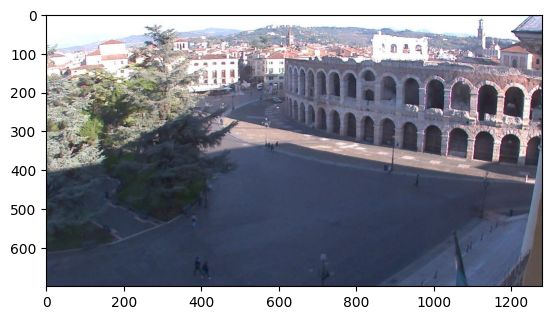

In [191]:
random_img_viz(train_img)

In [192]:
def standarized_input(image):
    # resize to w: 1100, h:600
    std_img = cv2.resize(image, (1100,600))

    return std_img

In [193]:
def label_encoder(label):
    # Encode the label
    # day as 1; night as 0
    num_val = 0

    if(label == 'day'):
        num_val = 1
    
    return num_val

In [194]:
def preprocess(img_list):
    std_img_list = []

    for item in img_list:
        image = item[0]
        label = item[1]

        # Standarized the image
        std_img = standarized_input(image)

        # Create the label
        img_label = label_encoder(label)

        std_img_list.append((std_img, img_label))
    
    return std_img_list

In [195]:
train_std_img_list = preprocess(train_img)

In [196]:
# Random size checking
pick_random = np.random.randint(0, len(train_std_img_list))

# Check img size
print(f'Image {pick_random}')
print(train_std_img_list[pick_random][0].shape)

Image 100
(600, 1100, 3)


Shape	: (600, 1100, 3)
Label	: 0


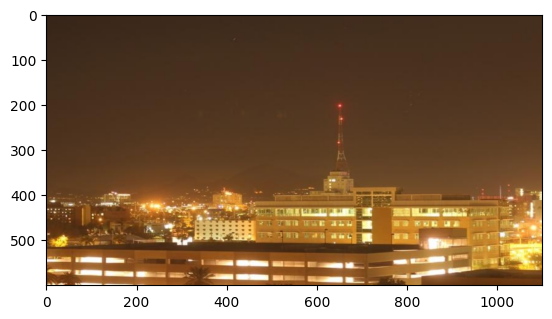

In [197]:
random_img_viz(train_std_img_list)

In [198]:
# Get feature based on average brightness using HSV colorspace
def avg_brightness(image):
    # Convert image to HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Calculate the avg of brightness
    sum_brightness = np.sum(img_hsv[:,:,2]) # take the 3rb value which is the V channel
    area = image.shape[0] * image.shape[1]
    avg = sum_brightness / area

    return avg

Image 214
Avg Brighness: 89.1060


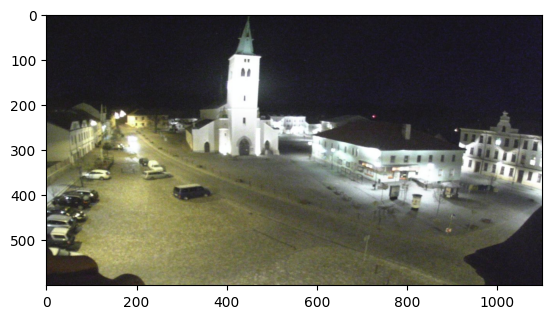

In [199]:
# Check on random image
rand_img = np.random.randint(0, len(train_std_img_list))

feature_img = train_std_img_list[rand_img][0]

avg_img = avg_brightness(feature_img)

print(f'Image {rand_img}')
print(f'Avg Brighness: {avg_img:.4f}')
plt.imshow(feature_img)

In [200]:
def predict_label(img, threshold):
    # Computer average brightness
    avg = avg_brightness(img)
    pred = 0

    # Predict the label based on user defined threshold
    if avg > threshold:
        pred = 1
    
    return pred

Image 107
Actual label: 1
Predicted label: 1


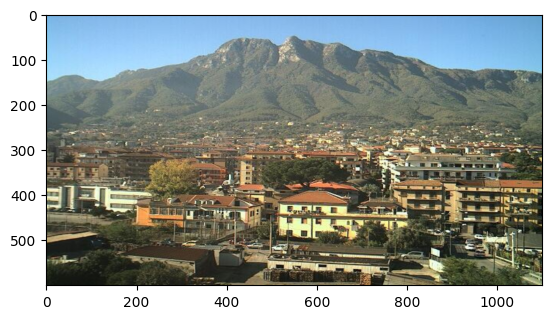

In [201]:
# Test the classifier on train data
rand_img = np.random.randint(0, len(train_std_img_list))

pred = predict_label(train_std_img_list[rand_img][0], threshold=120)

# Evaluate
print(f'Image {rand_img}')
print(f'Actual label: {train_std_img_list[rand_img][1]}')
print(f'Predicted label: {pred}')
plt.imshow(train_std_img_list[rand_img][0])

In [202]:
def evaluate(img_list, threshold):
    miss_labels = []

    for file in img_list:
        # Get the ground truth / correct label
        img = file[0]
        label = file[1]

        # Get prediction
        pred_label = predict_label(img, threshold)

        # Compare ground truth and pred
        if pred_label != label:
            miss_labels.append((img, pred_label, label))
    
    total_img = len(img_list)
    corr_pred = total_img - len(miss_labels)
    accuracy = corr_pred / total_img

    print(f'Accuracy: {accuracy:.4f}')

In [203]:
# Evaluate on train data
evaluate(train_std_img_list, threshold=120)

Accuracy: 0.8417


In [204]:
# Evaluate on test data

# Load test data
test_img = load_dataset(test_dir)

# Preprocess
test_std_img_list = preprocess(test_img)

# Predict
evaluate(test_std_img_list, threshold=120)

Accuracy: 0.8688


In [205]:
# Create function to extract feature for every images and stored in tabular data
# Stored in Pandas dataframe
def extract_avg_bright_feature(img_list):
    avg_list = []
    labels = []

    for img in img_list:
        img_avg = avg_brightness(img[0]) # Get the avg brightness from image
        img_label = img[1] # Get the image label

        avg_list.append(img_avg)
        labels.append(img_label)
    
    # Stack data in columcular way
    data = np.column_stack((avg_list, labels))
    # Create a Pandas dataframe
    df = pd.DataFrame(data, columns=['AVG_BRIGHT', 'LABELS'])

    return df

In [206]:
# Extract feature on train data
train_avg_img = extract_avg_bright_feature(train_std_img_list)
print(f'Shape: {train_avg_img.shape}')
train_avg_img.head()

Shape: (240, 2)


,AVG_BRIGHT,LABELS
0,175.092992,1.0
1,192.907867,1.0
2,132.133823,1.0
3,199.749191,1.0
4,109.947203,1.0


In [207]:
# Extract feature on train data
train_avg_img = extract_avg_bright_feature(train_std_img_list)
print(f'Shape: {train_avg_img.shape}')
train_avg_img.head()

Shape: (240, 2)


,AVG_BRIGHT,LABELS
0,175.092992,1.0
1,192.907867,1.0
2,132.133823,1.0
3,199.749191,1.0
4,109.947203,1.0
